In [12]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
# change the working directory to the location of ReconstructOrder on your machine 
#os.chdir('c:\\python\\ReconstructOrder')
# from compute.reconstruct import ImgReconstructor

#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
#from matplotlib.patches import Ellipse
#def extents(f):
#  delta = f[1] - f[0]
#  return [f[0] - delta/2, f[-1] + delta/2]


In [13]:
import numpy as np
import cv2

class ImgReconstructor:
    def __init__(self, img_pol, bg_method='Global', swing=None, wavelength=532,
                 kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 100)),
                 output_path=None, azimuth_offset=0):
        self.img_pol = img_pol
        self.bg_method = bg_method
        self.swing = swing*2*np.pi # covert swing from fraction of wavelength to radian
        self.n_chann = np.shape(img_pol)[0]
        self.height = np.shape(img_pol)[1]
        self.width = np.shape(img_pol)[2]
        self.wavelength = wavelength
        self.kernel = kernel
        self.output_path = output_path
        chi = self.swing
        if self.n_chann == 4:  # if the images were taken using 4-frame scheme
            inst_mat = np.array([[1, 0, 0, -1],
                                 [1, 0, np.sin(chi), -np.cos(chi)],
                                 [1, -np.sin(chi), 0, -np.cos(chi)],
                                 [1, 0, -np.sin(chi), -np.cos(chi)]])
        elif self.n_chann == 5:  # if the images were taken using 5-frame scheme
            inst_mat = np.array([[1, 0, 0, -1],
                                 [1, np.sin(chi), 0, -np.cos(chi)],
                                 [1, 0, np.sin(chi), -np.cos(chi)],
                                 [1, -np.sin(chi), 0, -np.cos(chi)],
                                 [1, 0, -np.sin(chi), -np.cos(chi)]])
        self.inst_mat_inv = np.linalg.pinv(inst_mat)
        self.azimuth_offset = azimuth_offset/180*np.pi

    def reconstruct_birefringence(self, stokes_param_sm, stokes_param_bg=None, circularity='rcp',
                           img_crop_ref=None, extra=False):
        # for low birefringence sample that requires 0 background, set extra=True to manually offset the background
        # Correction based on Eq. 16 in reference using linear approximation assuming small retardance for both sample and background

        # ASmBg = 0
        # s2_normSmBg = 0
        # if extra: # extra background correction to set backgorund = 0
        #     imList = [s1_normSm, s2_normSm]
        #     imListCrop = imcrop(imList, I_ext) # manually select ROI with only background retardance
        #     s1_normSmCrop,s2_normSmCrop = imListCrop
        #     s1_normSmBg = np.nanmean(s1_normSmCrop)
        #     s2_normSmBg = np.nanmean(s2_normSmCrop)

        def stokes_transform(stokes_param):
            [s0, s1, s2, s3] = stokes_param
            s1_norm = s1 / s3
            s2_norm = s2 / s3
            I_trans = s0
            polarization = np.sqrt(s1 ** 2 + s2 ** 2 + s3 ** 2) / s0
            return [I_trans, polarization, s1_norm, s2_norm, s3]

        def correct_background_stokes(stokes_param_sm, stokes_param_bg):
            [I_trans, polarization, s1_norm, s2_norm, s3] = stokes_param_sm
            [I_trans_bg, polarization_bg, s1_norm_bg, s2_norm_bg, s3_bg] = stokes_param_bg
            I_trans = I_trans / I_trans_bg
            polarization = polarization / polarization_bg
            s1_norm = s1_norm - s1_norm_bg
            s2_norm = s2_norm - s2_norm_bg
            return [I_trans, polarization, s1_norm, s2_norm, s3]

        def correct_background(stokes_param_sm, stokes_param_bg):
            if stokes_param_bg:
                stokes_param_bg = stokes_transform(stokes_param_bg)
                stokes_param_sm = correct_background_stokes(stokes_param_sm, stokes_param_bg)
                if self.bg_method == 'Local_filter':
                    stokes_param_bg_local = []
                    print('Estimating local background...')
                    for img in stokes_param_sm:
                        stokes_param_bg_local += [cv2.GaussianBlur(img, (401, 401), 0)]
                    stokes_param_sm = correct_background_stokes(stokes_param_sm, stokes_param_bg_local)
            return stokes_param_sm

        stokes_param_sm = stokes_transform(stokes_param_sm)
        stokes_param_sm = correct_background(stokes_param_sm, stokes_param_bg)
        [I_trans, polarization, s1_norm, s2_norm, s3] = stokes_param_sm
        s1 = s1_norm * s3
        s2 = s2_norm * s3
        retard = np.arctan2(np.sqrt(s1 ** 2 + s2 ** 2), s3)
        retard = retard / (2 * np.pi) * self.wavelength  # convert the unit to [nm]        
        if circularity == 'lcp':
            azimuth = (0.5 * np.arctan2(s1, -s2) + self.azimuth_offset)%(np.pi)  # make azimuth fall in [0,pi]
        elif circularity == 'rcp':
            azimuth = (0.5 * np.arctan2(-s1, -s2) + self.azimuth_offset) % (np.pi)  # make azimuth fall in [0,pi]
        return [I_trans, retard, azimuth, polarization]

    def calibrate_inst_mat(self):
        return

    def compute_stokes(self, img_raw):
        img_raw_flat = np.reshape(img_raw, (self.n_chann, self.height*self.width))
        img_stokes_flat = np.dot(self.inst_mat_inv, img_raw_flat)
        img_stokes = np.reshape(img_stokes_flat, (img_stokes_flat.shape[0], self.height, self.width))
        [s0, s1, s2, s3] = [img_stokes[i, :, :] for i in range(0, img_stokes.shape[0])]
        return [s0, s1, s2, s3]


# Forward model: specimen -> Intensity

## Specimen properties

### Case 1: retardance varies from 0 to full-wave

In [14]:
# coordinate grid
x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = 2*np.pi*np.sqrt(xx**2+yy**2)
retardance[retardance >2*np.pi] = 2*np.pi


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 2: retardance constant at half-wave

In [83]:
# coordinate grid

x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = np.pi*np.ones(xx.shape)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 3: retardance constant at quarter-wave 

In [96]:
# coordinate grid

x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to full-wave (2pi) over radius of 1, and then stays constant
retardance = 0.5*np.pi*np.ones(xx.shape)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission=np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Case 4: retardance varies from 0 to less than half-wave

In [15]:
# coordinate grid
x = np.linspace(-1.5,1.5,1024)
xx, yy = np.meshgrid(x,x)

# retardance: increases from 0 to less than half-wave (pi/2) 
retardance = 0.2*np.pi*np.sqrt(xx**2+yy**2)


# slowaxis assumed to rotate azimuthally. 
slowaxis = np.arctan2(yy,xx)%np.pi


# constant transmission and polarization
transmission = np.ones(xx.shape)
polarization=np.ones(xx.shape)

### Plot retardance, slow-axis, transmission, and polarization

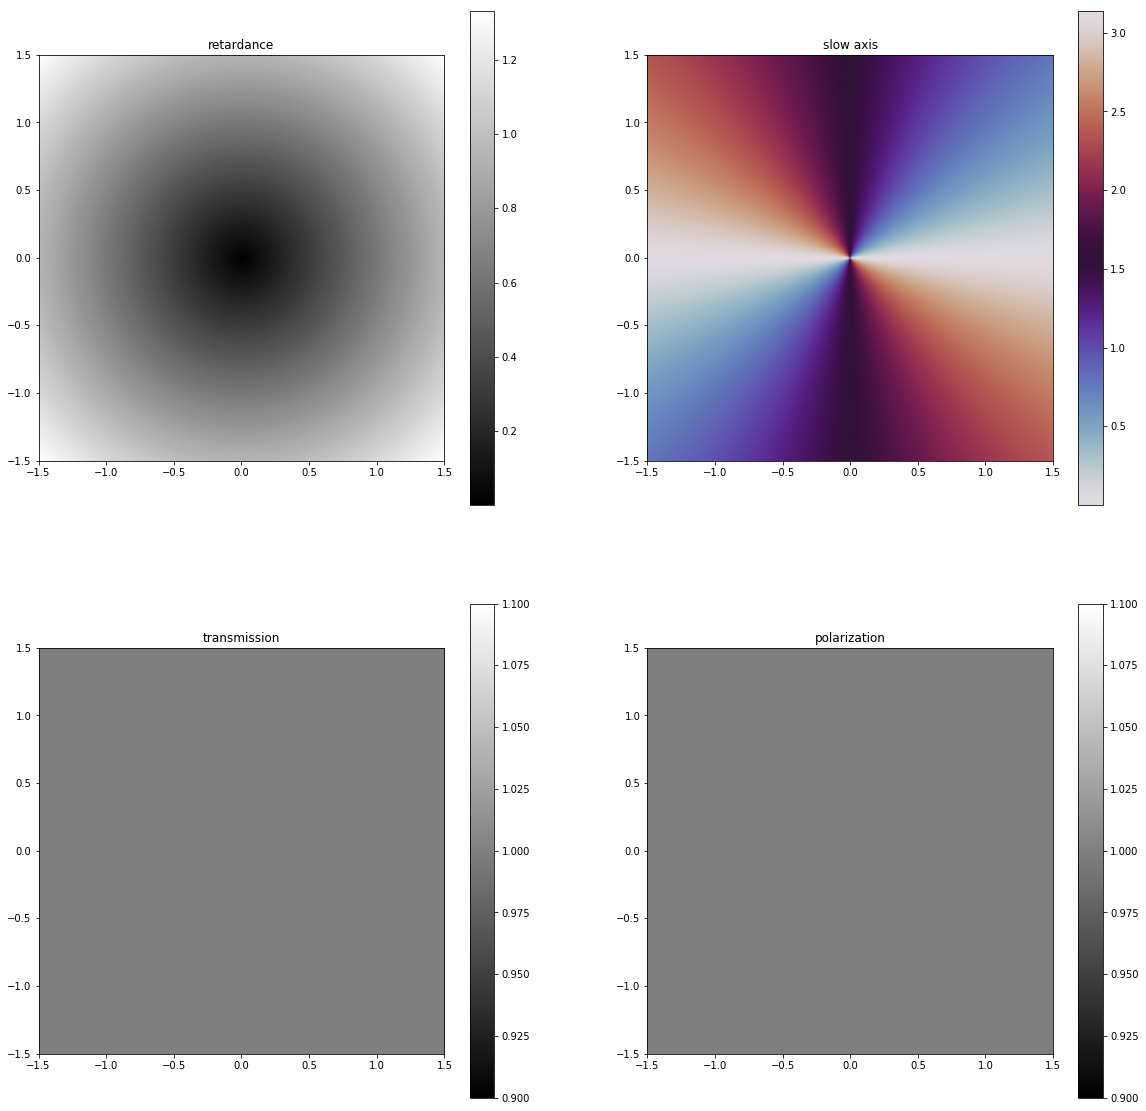

In [16]:
xyextent=[-1.5,1.5,-1.5,1.5]

fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(retardance,cmap='gray',extent=xyextent, origin='lower');
plt.title('retardance')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(slowaxis,cmap='twilight', extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('slow axis')
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(transmission,cmap='gray',extent=xyextent, origin='lower');
plt.title('Brightfield_computed')
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(polarization,cmap='gray',extent=xyextent, origin='lower');
plt.title('polarization')
ax4.figure.colorbar(im);


## Stokes parameters with right circularly polarized illumination

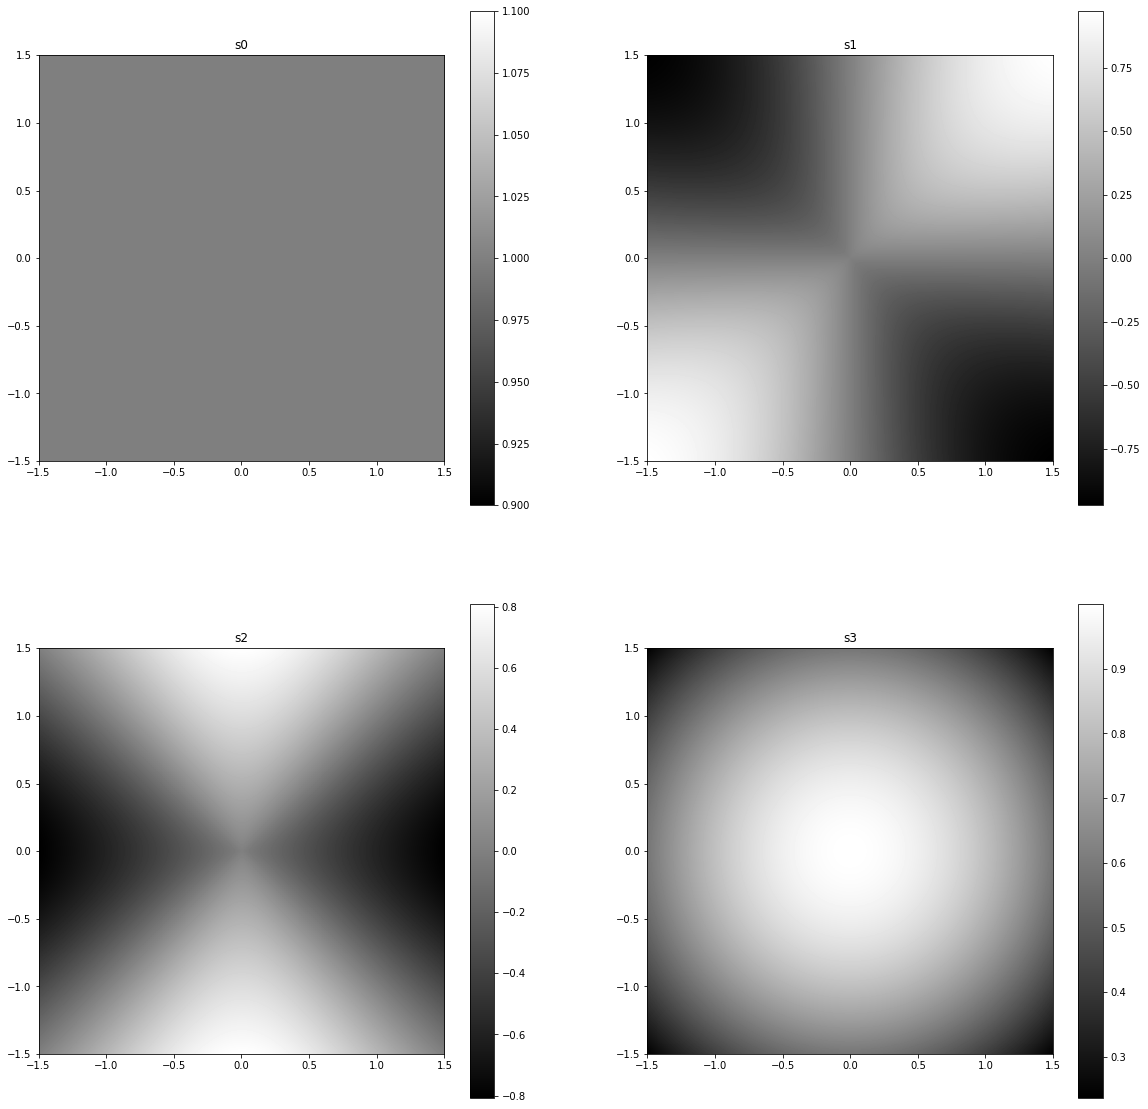

In [18]:
# Assumptions: right circularly polarized input. 
s0=transmission
s1=transmission*polarization*np.sin(2*slowaxis)*np.sin(retardance)
s2=-transmission*polarization*np.cos(2*slowaxis)*np.sin(retardance)
s3=transmission*polarization*np.cos(retardance)

fig2 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig2.add_subplot(2,2,1) 
im=plt.imshow(s0,cmap='gray',extent=xyextent, origin='lower');
plt.title('s0')
ax1.figure.colorbar(im);

ax2=fig2.add_subplot(2,2,2)
im=plt.imshow(s1,cmap='gray',extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('s1')
ax2.figure.colorbar(im);

ax3=fig2.add_subplot(2,2,3)
im=plt.imshow(s2,cmap='gray',extent=xyextent, origin='lower');
plt.title('s2')
ax3.figure.colorbar(im);

ax4=fig2.add_subplot(2,2,4)
im=plt.imshow(s3,cmap='gray',extent=xyextent, origin='lower');
plt.title('s3')
ax4.figure.colorbar(im);

## Intensity images

In [19]:
height,width=s0.shape
s=np.zeros((4,height,width))
s[0,:,:]=s0;  s[1,:,:]=s1; s[2,:,:]=s2; s[3,:,:]=s3;

"""
Swing of 0.25 or quarter-wave leads to linear analysis states. 
Since S1=I0-I90 and S2=I45-I135, the intensity patterns generated by 
"""
swing = 0.05
chi=2*np.pi*swing
StoIMatLC=np.array([ [1, 0, 0, -1],
                     [1, np.sin(chi), 0, -np.cos(chi)],
                     [1, 0, np.sin(chi), -np.cos(chi)],
                     [1, -np.sin(chi), 0, -np.cos(chi)],
                     [1, 0, -np.sin(chi), -np.cos(chi)]])
Svec=s.reshape(4,height*width)
Ivec=np.dot(StoIMatLC,Svec)
I=Ivec.reshape(5,height,width)
Iext=I[0,:,:]; I0=I[1,:,:]; I45=I[2,:,:]; I90=I[3,:,:]; I135=I[4,:,:];

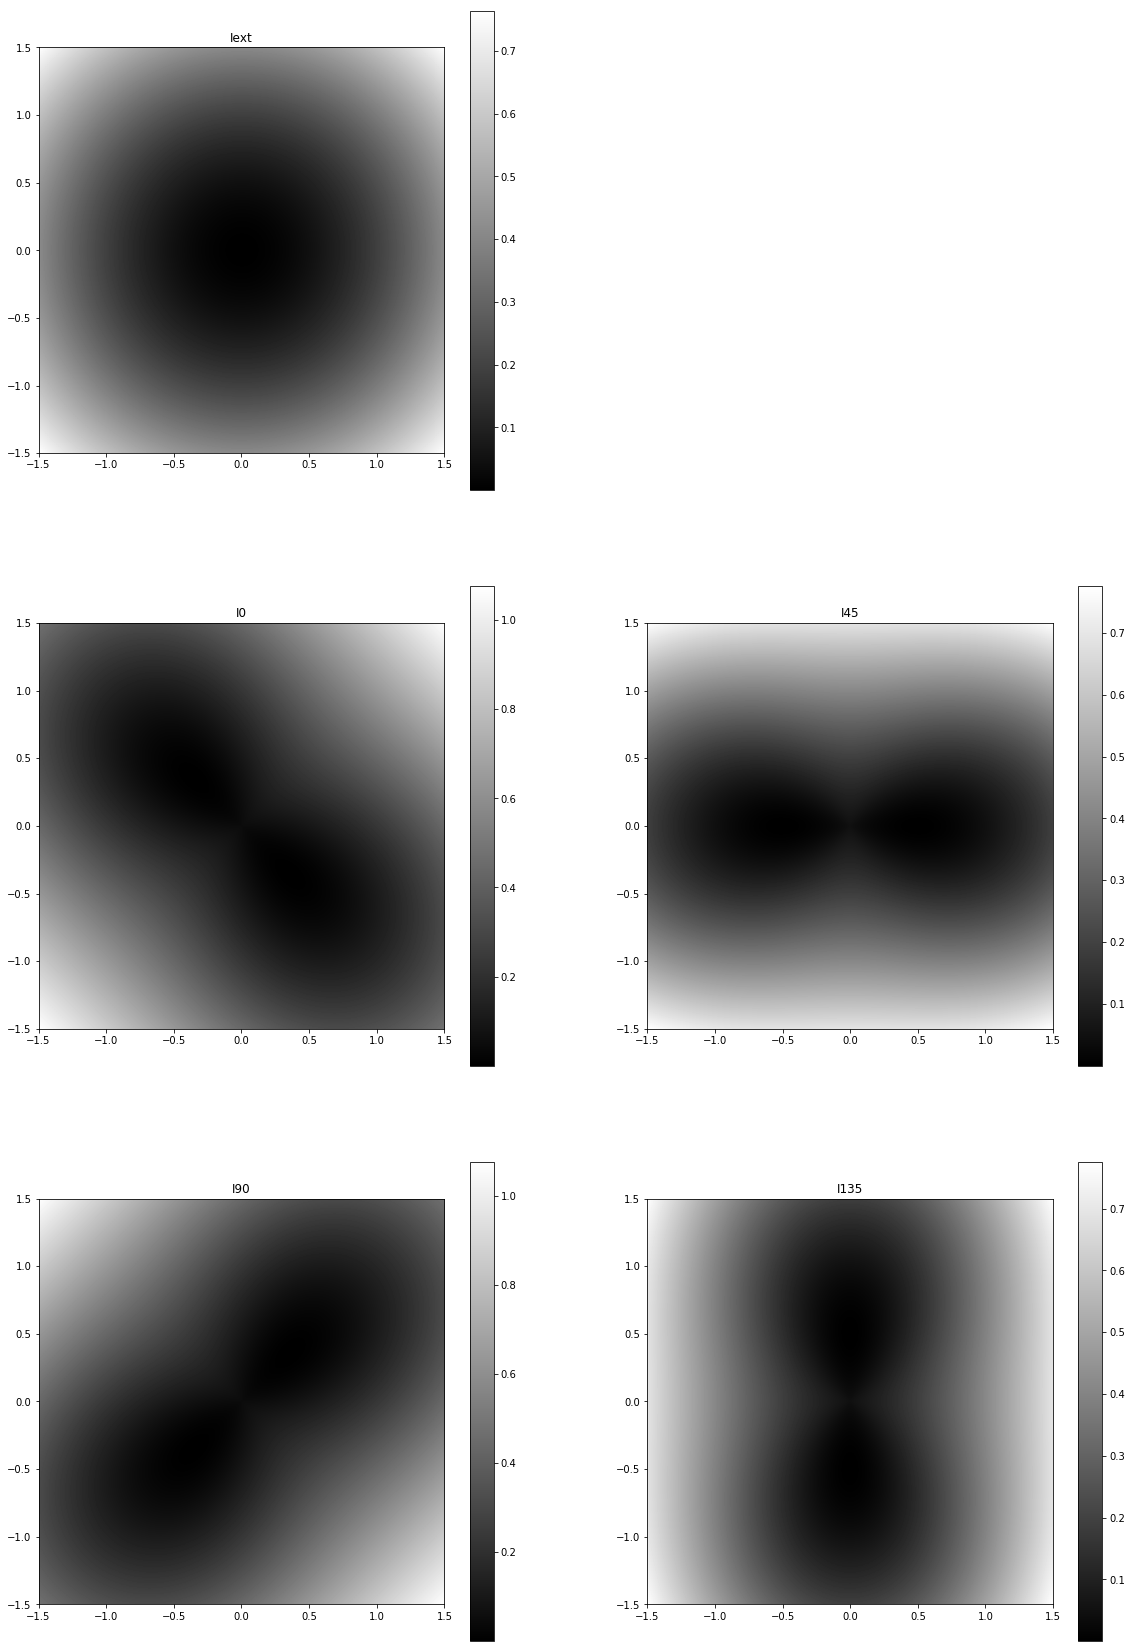

In [20]:
fig3 = plt.figure(figsize=(20,30)) # create a figure with the default size

ax1 = fig3.add_subplot(3,2,1) 
im=plt.imshow(Iext,cmap='gray',extent=xyextent,origin='lower');
plt.title('Iext')
ax1.figure.colorbar(im);

ax2=fig3.add_subplot(3,2,3)
im=plt.imshow(I0,cmap='gray',extent=xyextent,origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('I0')
ax2.figure.colorbar(im);

ax3=fig3.add_subplot(3,2,4)
im=plt.imshow(I45,cmap='gray',extent=xyextent,origin='lower');
plt.title('I45')
ax3.figure.colorbar(im);

ax4=fig3.add_subplot(3,2,5)
im=plt.imshow(I90,cmap='gray',extent=xyextent,origin='lower');
plt.title('I90')
ax4.figure.colorbar(im);

ax5=fig3.add_subplot(3,2,6)
im=plt.imshow(I135,cmap='gray',extent=xyextent,origin='lower');
plt.title('I135')
ax4.figure.colorbar(im);

In [21]:
wavelength = 2 * np.pi
circularity = 'rcp'
# azimuth_offset = 90
azimuth_offset = 0
img_reconstructor = ImgReconstructor(I, bg_method='Global', swing=swing,
                                         wavelength=wavelength, azimuth_offset = azimuth_offset)

s = img_reconstructor.compute_stokes(I)
        
[transmission, retardance, slowaxis, polarization] = img_reconstructor.reconstruct_birefringence(
                                                            s, stokes_param_bg=None, circularity=circularity)                                                                                                                            
[s0, s1, s2, s3] = s
# slowaxis = 0.5 * ((np.arctan2(-s1, s2)+ 2*np.pi)%(2*np.pi))+ azimuth_offset  # make azimuth fall in [0,pi]

In [22]:
print('dynamic range of polarization {}'.format(np.max(polarization)-np.min(polarization)))


dynamic range of polarization 1.0880185641326534e-14


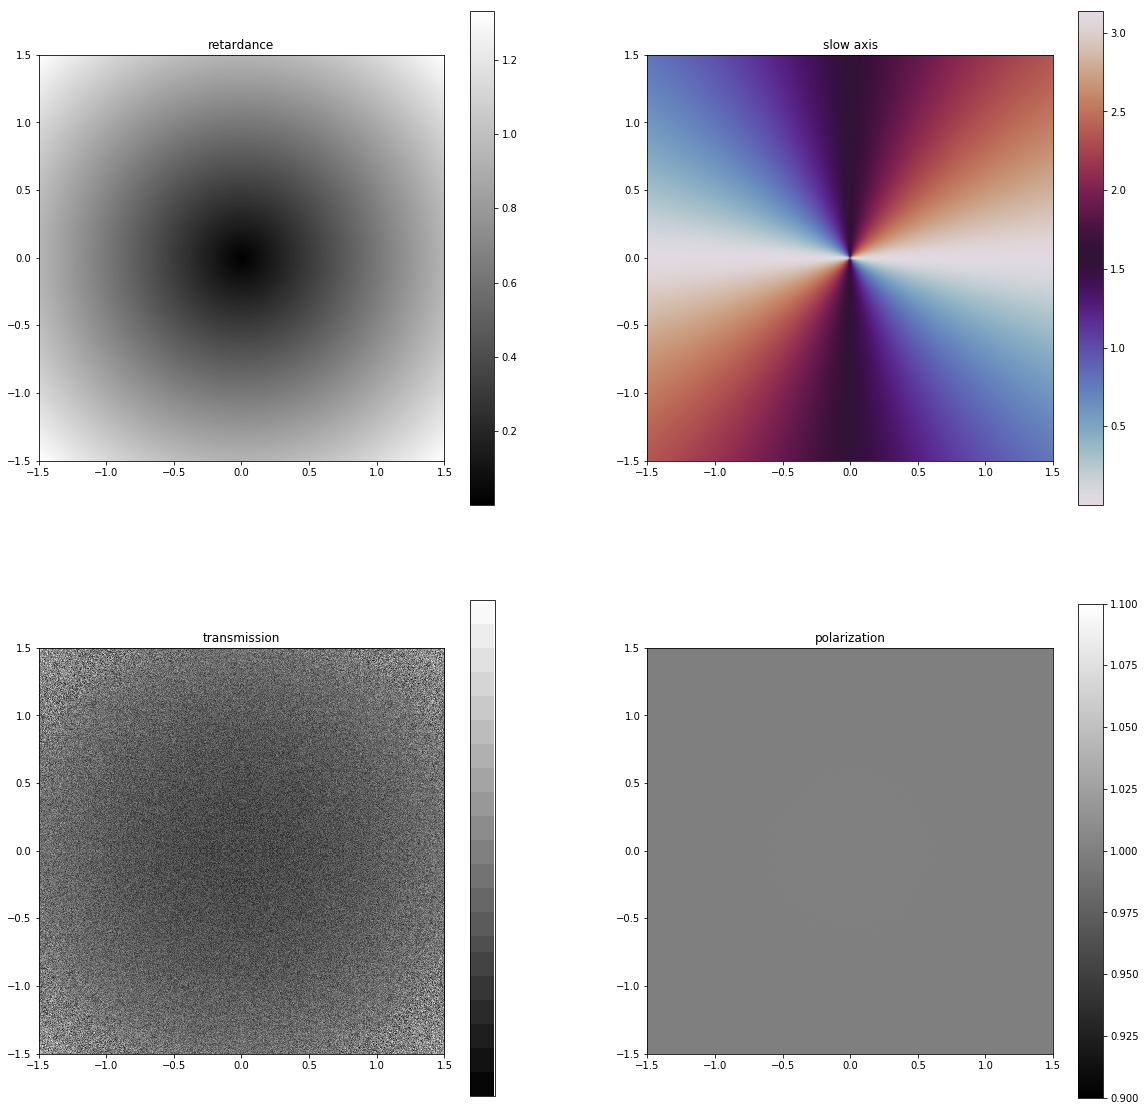

In [23]:
xyextent=[-1.5,1.5,-1.5,1.5]

fig1 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig1.add_subplot(2,2,1) 
im=plt.imshow(retardance,cmap='gray',extent=xyextent, origin='lower');
plt.title('retardance')
ax1.figure.colorbar(im);

ax2=fig1.add_subplot(2,2,2)
im=plt.imshow(slowaxis,cmap='twilight', extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('slow axis')
ax2.figure.colorbar(im);

ax3=fig1.add_subplot(2,2,3)
im=plt.imshow(transmission,cmap='gray',extent=xyextent, origin='lower');
plt.title('Brightfield_computed')
ax3.figure.colorbar(im);

ax4=fig1.add_subplot(2,2,4)
im=plt.imshow(polarization,cmap='gray',extent=xyextent, origin='lower', vmin=0.9, vmax=1.1);
plt.title('polarization')
ax4.figure.colorbar(im);


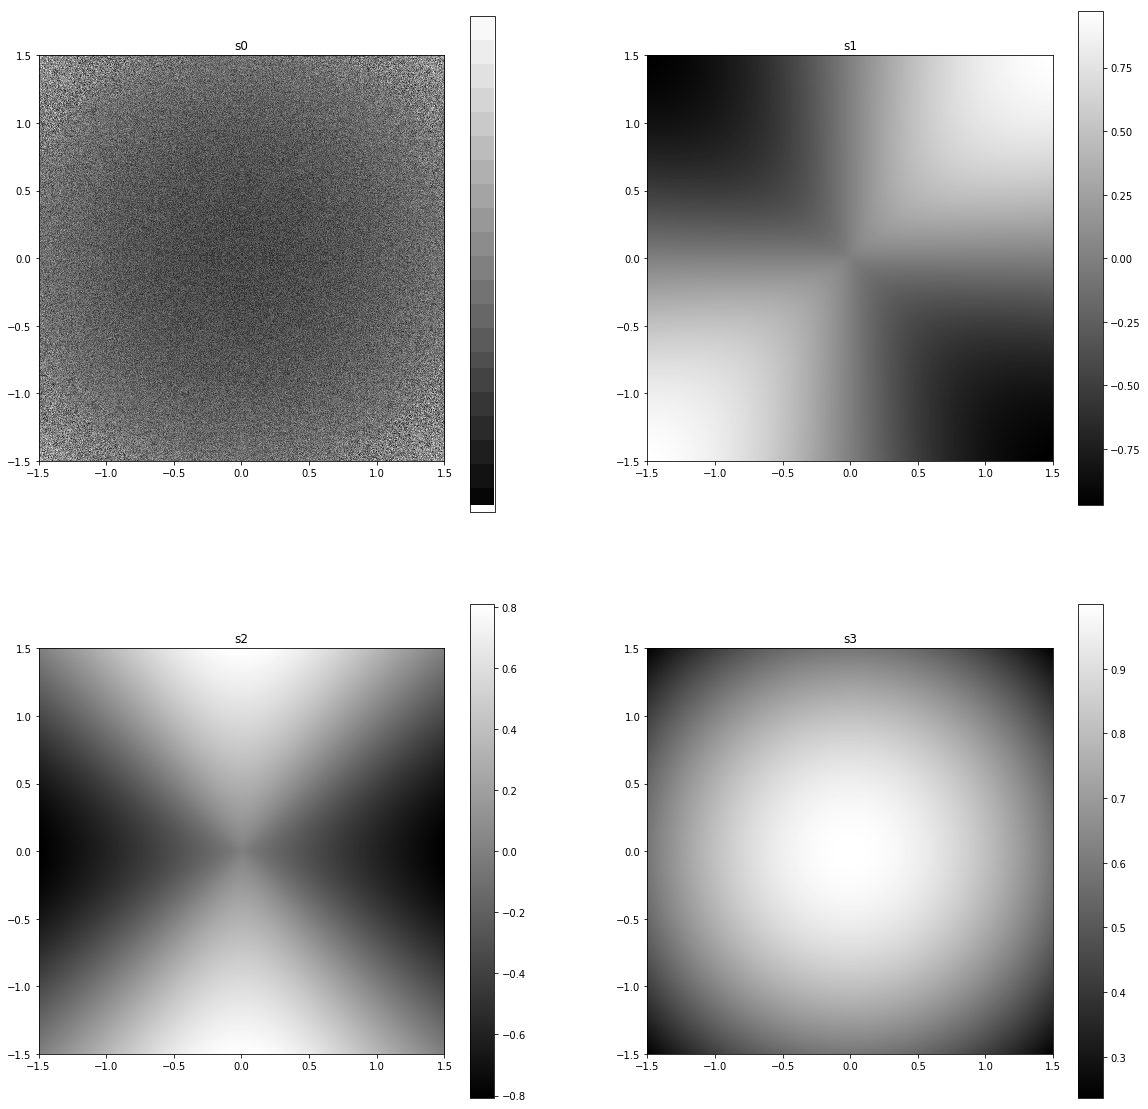

In [24]:
fig2 = plt.figure(figsize=(20,20)) # create a figure with the default size 

ax1 = fig2.add_subplot(2,2,1) 
im=plt.imshow(s0,cmap='gray',extent=xyextent, origin='lower');
plt.title('s0')
ax1.figure.colorbar(im);

ax2=fig2.add_subplot(2,2,2)
im=plt.imshow(s1,cmap='gray',extent=xyextent, origin='lower'); # Need to adapt this look up table to represent orientation.
plt.title('s1')
ax2.figure.colorbar(im);

ax3=fig2.add_subplot(2,2,3)
im=plt.imshow(s2,cmap='gray',extent=xyextent, origin='lower');
plt.title('s2')
ax3.figure.colorbar(im);

ax4=fig2.add_subplot(2,2,4)
im=plt.imshow(s3,cmap='gray',extent=xyextent, origin='lower');
plt.title('s3')
ax4.figure.colorbar(im);

In [ ]:
x=np.